In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Adaptive boost (adaboost)

틀린내용을 복습하는 개념인듯 하다.

misclassified 된 rows를 모아서 다시 훈련을 한다.

* AdaBoost is a nice algorithm to demonstrate the internal machinery of boosting algorithms

In [4]:
penguins = pd.read_csv("data/penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

data, target = penguins[culmen_columns], penguins[target_column]

In [5]:
from sklearn.tree import DecisionTreeClassifier

palette = ["tab:red",'tab:blue','black']

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data,target)


DecisionTreeClassifier(max_depth=2, random_state=0)

### flatnonzero => 0이 아닌 값들의 순서를 반환한다.
x = np.arange(-2, 3)
> array([-2, -1,  0,  1,  2])


np.flatnonzero(x)
> array([0, 1, 3, 4])

In [7]:
target_predicted = tree.predict(data)

### 예측에 실패한 row들을 불러오는 명령어
misclassified_samples_idx = np.flatnonzero(target != target_predicted)
data_misclassified = data.iloc[misclassified_samples_idx]

In [11]:
misclassified_samples_idx

array([ 16,  18,  42,  72,  74,  80,  98, 108, 110, 114, 128, 130, 184,
       188, 216, 230, 236, 240, 242, 250, 252, 304], dtype=int64)

### Sample_weight
Sample 중에 정해진 Sample에게 중요도를 부과해 더욱 높은 가중치를 부여하는 방법

### np.zeros_like
특정 array의 shape를 복사하고 내용은 비우게(0으로) 만드는 명령어
> 유사 명령어로 np.zero가 있음 원하는 shape를 직접 설정하는 방법임

In [13]:
### 개별 row and columns 별로 Weight 값설정하기
sample_weight = np.zeros_like(target, dtype=int)
sample_weight[misclassified_samples_idx] = 1

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(data, target, sample_weight=sample_weight)

DecisionTreeClassifier(max_depth=2, random_state=0)

### sample weight parameter 유무 decision boundary 차이

**Sample-Weight 미적용**
![a](data/20.png)

**Sample-Weight 적용**
![a](data/21.png)

In [25]:
target_predicted = tree.predict(data)
newly_misclassified_samples_idx = np.flatnonzero(target != target_predicted)
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx
)

print(f"Number of samples previously misclassified and "
      f"still misclassified: {len(remaining_misclassified_samples_idx)}")

Number of samples previously misclassified and still misclassified: 0


* misclassified가 0이라는 말은 Weight를 1로 가중치를 둔 instance들을 위주로 modeling을 진행했다는 말임.

* np.intersect1d  => 교집합을 구하는 매소드

In [26]:
### 모델 정확도 계산
ensemble_weight = [
    (target.shape[0] - len(misclassified_samples_idx)) / target.shape[0],
    (target.shape[0] - len(newly_misclassified_samples_idx)) / target.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

* misclassified_samples_idx : 맨 처음 tree로 구한 mis개수

* newly_misclassified_samples_idx : mis 개수에 weight를 줘서 교육시킨 model에서 발생한 mis 개수

* We could use these accuracy values to weight the predictions of each learner. 라고 하는데 정확도를 가지고 model에 가중치를 준다는게 뭔말인지 이해가 어렵네..
  
맨처음 올바르게 식별된 경우에 가중치를 줘서 해당 instance들을 먼저 학습한다음 나머지를 학습시키는건가.. 

근데 1번과 2번에서 둘다 올바르게 분류된 경우에는 가중치 둘 중에 무엇을 택해야하는거지?


### boosting과 bagging 차이점
* boosting learns several classifiers, each of which will focus more or less on specific samples of the dataset. 
  
* Boosting is thus different from bagging: here we never resample our dataset, we just assign different weights to the original dataset.

In [31]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=3, algorithm='SAMME', random_state=0)

adaboost.fit(data,target)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   n_estimators=3, random_state=0)

![a](data/22.png)

In [32]:
print(f"Weight of each classifier: {adaboost.estimator_weights_}")

Weight of each classifier: [3.58351894 3.46901998 3.03303773]


misclassfied 된 instance에 가중치를 주는 방식으로 학습을 3번 수행함.

### Gradient-boosting decision tree (GBDT)¶
 GBDT will fit a decision tree on the residuals error (hence the name “gradient”) of the previous tree. Therefore, each new tree in the ensemble predicts the error made by the previous learner instead of predicting the target directly.

In [33]:
import pandas as pd
import numpy as np

# Create a random number generator that will be used to set the randomness
rng = np.random.RandomState(0)


def generate_data(n_samples=50):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_max, x_min = 1.4, -1.4
    len_x = x_max - x_min
    x = rng.rand(n_samples) * len_x - len_x / 2
    noise = rng.randn(n_samples) * 0.3
    y = x ** 3 - 0.5 * x ** 2 + noise

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(np.linspace(x_max, x_min, num=300),
                             columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train


data_train, data_test, target_train = generate_data()

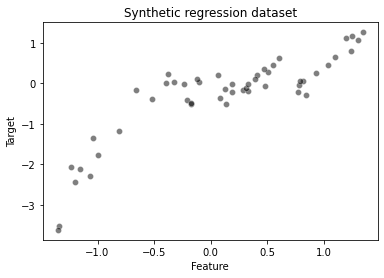

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)

target_train_predicted = tree.predict(data_train)
target_test_predicted = tree.predict(data_test)

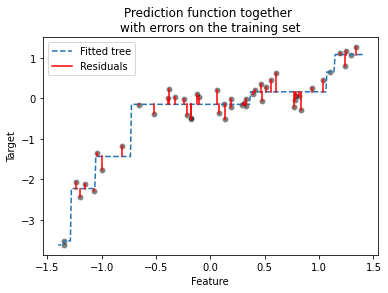

In [36]:
# plot the data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
# plot the predictions
line_predictions = plt.plot(data_test["Feature"], target_test_predicted, "--")

# plot the residuals
for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"])
_ = plt.title("Prediction function together \nwith errors on the training set")

설명에는 underfit되었다는데.. 많이 꾸불거려야 sweetspot으로 인정되는건가?

Residuals :  difference between the predictions and the ground-truth data.

In a gradient-boosting algorithm, the idea is to create a second tree which, given the same data data, will try to predict the residuals instead of the vector target.

We would therefore have a tree that is able to predict the errors made by the initial tree.

error를 예측하는 tree를 새로 만든다..? 무슨 말이지?

In [37]:
residuals = target_train - target_train_predicted

tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
tree_residuals.fit(data_train, residuals)

target_train_predicted_residuals = tree_residuals.predict(data_train)
target_test_predicted_residuals = tree_residuals.predict(data_test)

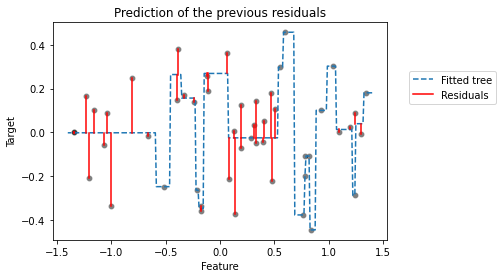

In [47]:
sns.scatterplot(x=data_train["Feature"], y=residuals, color="black", alpha=0.5)
line_predictions = plt.plot(
    data_test["Feature"], target_test_predicted_residuals, "--")

# plot the residuals of the predicted residuals
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"], bbox_to_anchor=(1.05, 0.8),
           loc="upper left")
_ = plt.title("Prediction of the previous residuals")

위 plot은 Residual이 발생한 값들만 모아서 다시 tree를 돌린 결과임


In [48]:
sample = data_train.iloc[[-2]]
x_sample = sample['Feature'].iloc[0]
target_true = target_train.iloc[-2]
target_true_residual = residuals.iloc[-2]

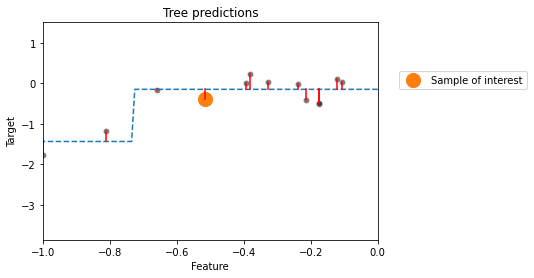

In [57]:
# Plot the previous information:
#   * the dataset
#   * the predictions
#   * the residuals

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
plt.plot(data_test["Feature"], target_test_predicted, "--")
for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(sample, target_true, label="Sample of interest",
            color="tab:orange", s=200)
plt.xlim([-1, 0]) ## 이것 때문에 그림이 달라보임
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Tree predictions")

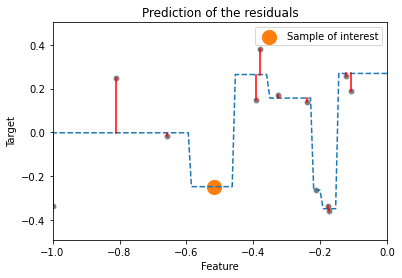

In [55]:
# Plot the previous information:
#   * the residuals committed by the first tree
#   * the residual predictions
#   * the residuals of the residual predictions

### Residudal 그래프 
sns.scatterplot(x=data_train["Feature"], y=residuals,
                color="black", alpha=0.5)
plt.plot(data_test["Feature"], target_test_predicted_residuals, "--")
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(sample, target_true_residual, label="Sample of interest",
            color="tab:orange", s=200)
plt.xlim([-1, 0]) ### 이것 때문에 그림이 달라보임
plt.legend()
_ = plt.title("Prediction of the residuals")

*  Sample of interest를 보면 sample이 error를 가지고 있다. 두번째 error 보정을 거쳐서 정확히 예측 범위 안에 속해있다.(error가 0이다.)

We will quantitatively check this prediction using the fitted tree.

In [58]:
print(f"True value to predict for "
      f"f(x={x_sample:.3f}) = {target_true:.3f}")

y_pred_first_tree = tree.predict(sample)[0]
print(f"Prediction of the first decision tree for x={x_sample:.3f}: "
      f"y={y_pred_first_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_tree:.3f}")

True value to predict for f(x=-0.517) = -0.393
Prediction of the first decision tree for x=-0.517: y=-0.145
Error of the tree: -0.248


In [59]:
print(f"Prediction of the residual for x={x_sample:.3f}: "
      f"{tree_residuals.predict(sample)[0]:.3f}")

Prediction of the residual for x=-0.517: -0.248


In [61]:
y_pred_first_and_second_tree = (
    y_pred_first_tree + tree_residuals.predict(sample)[0]
)
print(f"Prediction of the first and second decision trees combined for "
      f"x={x_sample:.3f}: y={y_pred_first_and_second_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_and_second_tree:.3f}")

Prediction of the first and second decision trees combined for x=-0.517: y=-0.393
Error of the tree: 0.000


### 개념정도로만 이해하자..
1. GBDT는 decision tree에 관한 boosting 방법이다.
2. 틀린 내용을 중점으로 학습하는 adaboost와 다르게 오차를 예측(?)하는 decision tree를 우선 만든 뒤 2차적으로 decision tree를 만들어서 predict를 하는 방법을 수행한다. 
사실 아리까리 함..

We chose a sample for which only two trees were enough to make the perfect prediction. However, we saw in the previous plot that two trees were not enough to correct the residuals of all samples. 

Therefore, one needs to add several trees to the ensemble to successfully correct the error 

GBDT를 설명하는 예시는 하나의 residual에만 해당하는 것이고 실제로는 수많은 tree를 만들어서 residual을 점차 적용시켜야 함.

In [62]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_validate

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [64]:
print("Gradient Boosting Decision Tree")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 46.443 +/- 2.914 k$
Average fit time: 8.968 seconds
Average score time: 0.012 seconds


In [65]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=200, n_jobs=2)
cv_results_rf = cross_validate(
    random_forest, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [66]:
print("Random Forest")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_rf['test_score'].mean():.3f} +/- "
      f"{cv_results_rf['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_rf['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_rf['score_time'].mean():.3f} seconds")

Random Forest
Mean absolute error via cross-validation: 46.530 +/- 4.449 k$
Average fit time: 21.589 seconds
Average score time: 0.153 seconds


### Random_Forest VS GBDT

In term of computation performance, the forest can be parallelized and will benefit from using multiple cores of the CPU. In terms of scoring performance, both algorithms lead to very close results.

However, we see that the gradient boosting is a very fast algorithm to predict compared to random forest. This is due to the fact that gradient boosting uses shallow trees. We will go into details in the next notebook about the hyperparameters to consider when optimizing ensemble methods.

In [67]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5)

In [70]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import validation_curve


gradient_boosting = GradientBoostingRegressor(max_depth=5,learning_rate=0.5)

random_forest = RandomForestRegressor(max_depth=None)



max_depth = [1,5,10,15,20,50,100]

train_scores_gra, test_scores_gra = validation_curve(gradient_boosting,data,target, param_name='max_depth', param_range=max_depth, scoring='neg_mean_absolute_error', n_jobs= -1)

train_errors_gra, test_errors_gra = -train_scores_gra, -test_scores_gra

train_scores_fore, test_scores_fore = validation_curve(gradient_boosting,data,target, param_name='max_depth', param_range=max_depth, scoring='neg_mean_absolute_error', n_jobs= -1)

train_errors_fore, test_errors_fore = -train_scores_fore, -test_scores_fore

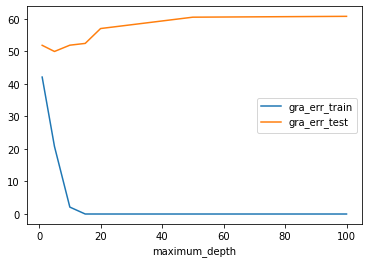

Text(0.5, 0, 'maximum_depth')

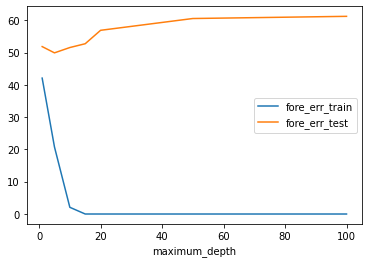

In [74]:
plt.plot(max_depth,train_errors_gra.mean(axis=1), label='gra_err_train')
plt.plot(max_depth,test_errors_gra.mean(axis=1), label='gra_err_test')
plt.legend()
plt.xlabel('maximum_depth')

plt.show()


plt.plot(max_depth,train_errors_fore.mean(axis=1), label='fore_err_train')
plt.plot(max_depth,test_errors_fore.mean(axis=1), label='fore_err_test')
plt.legend()
plt.xlabel('maximum_depth')

### GBDT가 그려지다 만 이유
To avoid adding new unnecessary tree, unlike random-forest gradient-boosting offers an early-stopping option.

In [76]:
# solution
from sklearn.model_selection import validation_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(max_depth=None)

gbdt = GradientBoostingRegressor(max_depth=5, learning_rate=0.5)

param_range = [1, 2, 5, 10, 20, 50, 100]
gbdt_train_scores, gbdt_validation_scores = validation_curve(
    gbdt,
    data_train,
    target_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
gbdt_train_errors, gbdt_validation_errors = -gbdt_train_scores, -gbdt_validation_scores

forest_train_scores, forest_validation_scores = validation_curve(
    forest,
    data_train,
    target_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
forest_train_errors = -forest_train_scores
forest_validation_errors = -forest_validation_scores

KeyboardInterrupt: 

In [ ]:
# solution
from sklearn.model_selection import validation_curve

param_range = [1, 2, 5, 10, 20, 50, 100]
gbdt_train_scores, gbdt_validation_scores = validation_curve(
    gbdt,
    data_train,
    target_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
gbdt_train_errors, gbdt_validation_errors = -gbdt_train_scores, -gbdt_validation_scores

forest_train_scores, forest_validation_scores = validation_curve(
    forest,
    data_train,
    target_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
forest_train_errors = -forest_train_scores
forest_validation_errors = -forest_validation_scores